In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.ensemble import VotingClassifier

In [2]:
"""Retourne le dataset nettoyé et transformé"""
def ETL(dataset_file, label_file=None, simplified=True):
    data = pd.read_csv(dataset_file,sep = ",")
    if(label_file != None): #rajout de la colonne des étiquettes
        y = pd.read_csv(label_file, sep = ",")
        data = pd.merge(y, data, left_index=True, right_index=True).rename(columns={'0.0': 'y'})
    data = data.dropna() #retire les lignes vides
    format_date = "%Y-%m-%d %H:%M:%S"
    #détermination de la date minimale dans le dataset
    epoch_time = dt.datetime(2018, 1, 1)
    delta = min([(dt.datetime.strptime(time_data, format_date) - epoch_time).total_seconds() for time_data in data['data_hour']])
    date_min = epoch_time + dt.timedelta(seconds = delta)
    #conversion data_hour -> temps écoulé depuis la première date
    secs_elapsed = pd.DataFrame(np.array([[(dt.datetime.strptime(time_data, format_date) -\
                                        date_min).total_seconds()]\
                                       for time_data in data['data_hour']]))
    data = pd.merge(secs_elapsed, data, left_index=True, right_index=True).rename(columns={0: 'secs_elapsed'})
    if(label_file != None):
        temp = data.iloc[:, 0].copy()
        data.iloc[:, 0] = data.iloc[:, 1]
        data.iloc[:, 1] = temp
        col_list = list(data)
        col_list[0], col_list[1] = col_list[1], col_list[0]
        data.columns = col_list
    data = data.drop(labels=['data_hour', 'idCow'], axis=1)
    if(simplified): #simplification du jeu de données
        num_col = data.shape[1]
        mean_all = pd.DataFrame(np.mean(data.iloc[:, 2:num_col:3], axis=1), columns=['mean_all'])
        mean_rest = pd.DataFrame(np.mean(data.iloc[:, 3:num_col:3], axis=1), columns=["mean_rest"])
        mean_eat = pd.DataFrame(np.mean(data.iloc[:, 4:num_col:3], axis=1), columns=["mean_eat"])
        data = pd.merge(mean_all, mean_rest, left_index=True, right_index=True)
        data = pd.merge(data, mean_eat, left_index=True, right_index=True)
        data = pd.merge(secs_elapsed, data, left_index=True, right_index=True)
        if(label_file != None):
            data = pd.merge(y, data, left_index=True, right_index=True)
            data.columns = ['y', 'secs_elapsed', 'mean_all', 'mean_rest', 'mean_eat']
        else:
            data.columns = ['secs_elapsed', 'mean_all', 'mean_rest', 'mean_eat']
    return data

In [3]:
data = ETL('xTrain.csv', label_file='yTrain.csv', simplified=True)
dataEval = ETL('xEval.csv', simplified=True)
complete_data = ETL('xTrain.csv', label_file='yTrain.csv', simplified=False)
complete_dataEval = ETL('xEval.csv', simplified=False)

In [4]:
data.describe()

,y,secs_elapsed,mean_all,mean_rest,mean_eat
count,86349.000000,8.634900e+04,86349.000000,86349.000000,86349.000000
mean,0.067053,7.819551e+06,774.162427,1861.726152,957.740692
std,0.250116,4.158635e+06,289.619558,350.301806,229.606226
min,0.000000,0.000000e+00,86.766250,0.000000,107.717875
25%,0.000000,4.248000e+06,580.446917,1668.143042,826.687667
50%,0.000000,7.520400e+06,725.756167,1886.526750,966.268542
75%,0.000000,1.141560e+07,906.990500,2087.660708,1091.911042
max,1.000000,1.499400e+07,3185.691667,3180.940500,3512.899083


In [5]:
"""Standardisation"""
data.iloc[:, 1:5] = MinMaxScaler().fit(data.iloc[:, 1:5]).transform(data.iloc[:, 1:5])
dataEval.iloc[:,0:4] = MinMaxScaler().fit(dataEval.iloc[:,0:4]).transform(dataEval.iloc[:,0:4])
complete_data.iloc[:, 1:complete_data.shape[1]] = MinMaxScaler().fit(complete_data.iloc[:, 1:complete_data.shape[1]]).transform(complete_data.iloc[:, 1:complete_data.shape[1]])
complete_dataEval.iloc[:, 0:complete_dataEval.shape[1]] = MinMaxScaler().fit(complete_dataEval.iloc[:, 0:complete_dataEval.shape[1]]).transform(complete_dataEval.iloc[:, 0:complete_dataEval.shape[1]])

In [6]:
y = data['y'] # Labels
X_simplified = data.drop(labels=['y'], axis=1) # Features

In [7]:
data.describe()

,y,secs_elapsed,mean_all,mean_rest,mean_eat
count,86349.000000,86349.000000,86349.000000,86349.000000,86349.000000
mean,0.067053,0.521512,0.221818,0.585275,0.249626
std,0.250116,0.277353,0.093458,0.110125,0.067428
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.283313,0.159307,0.524418,0.211140
50%,0.000000,0.501561,0.206197,0.593072,0.252131
75%,0.000000,0.761345,0.264680,0.656303,0.289028
max,1.000000,1.000000,1.000000,1.000000,1.000000


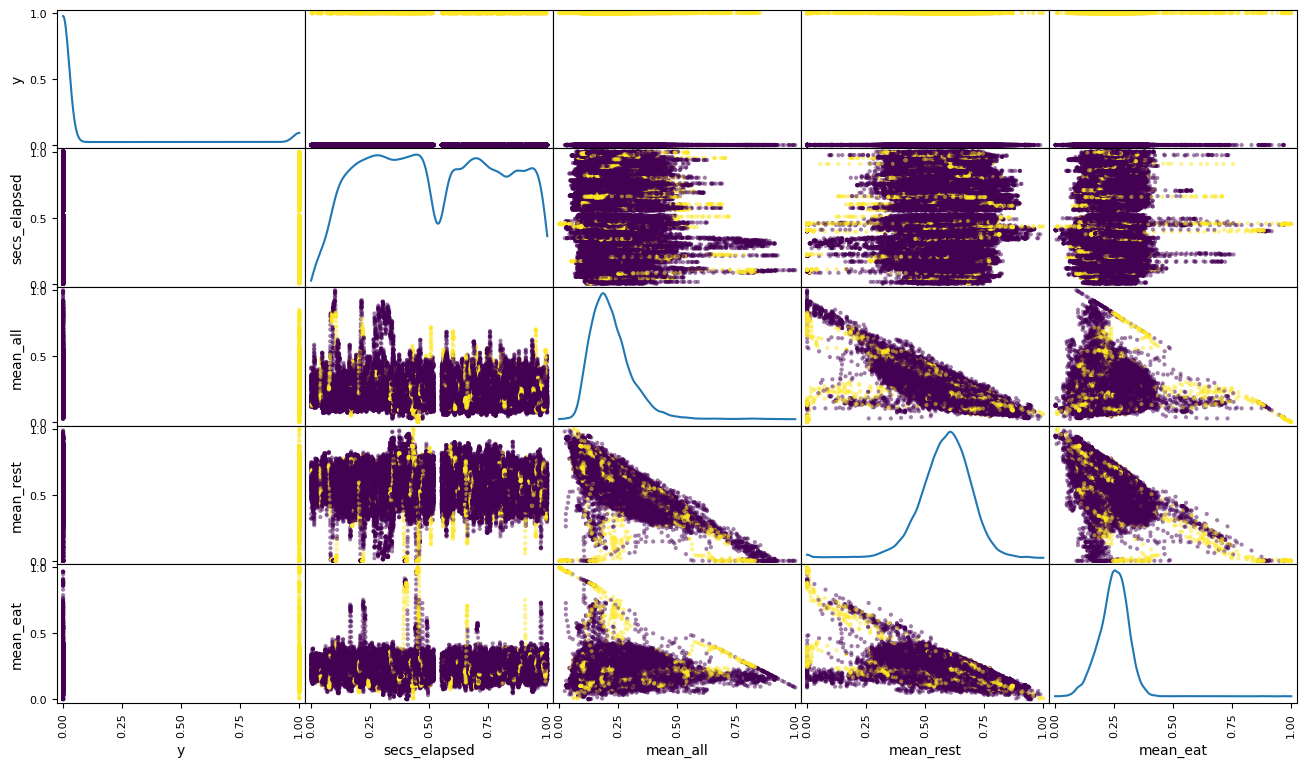

In [8]:
fig = pd.plotting.scatter_matrix(data, diagonal='kde', figsize=(16, 9), c=data['y'])

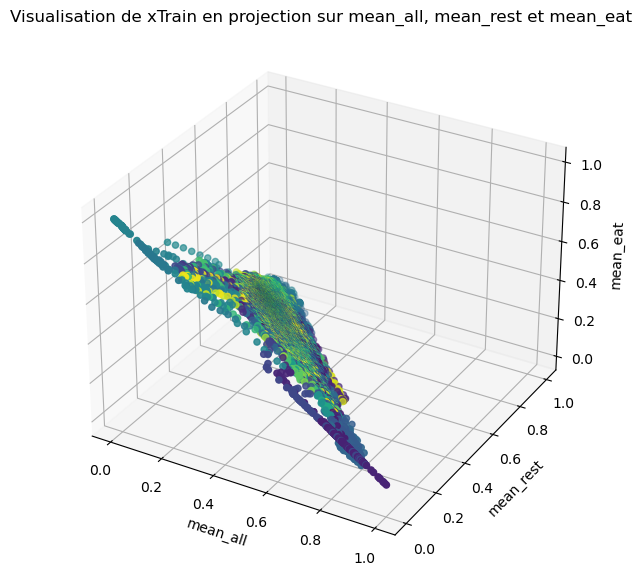

In [9]:
"""Visualisation des données simplifiées"""
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(data['mean_all'], data['mean_rest'], data['mean_eat'], c=data['secs_elapsed'])
ax.set_xlabel('mean_all')
ax.set_ylabel('mean_rest')
ax.set_zlabel('mean_eat')
plt.title("Visualisation de xTrain en projection sur mean_all, mean_rest et mean_eat")
plt.show()

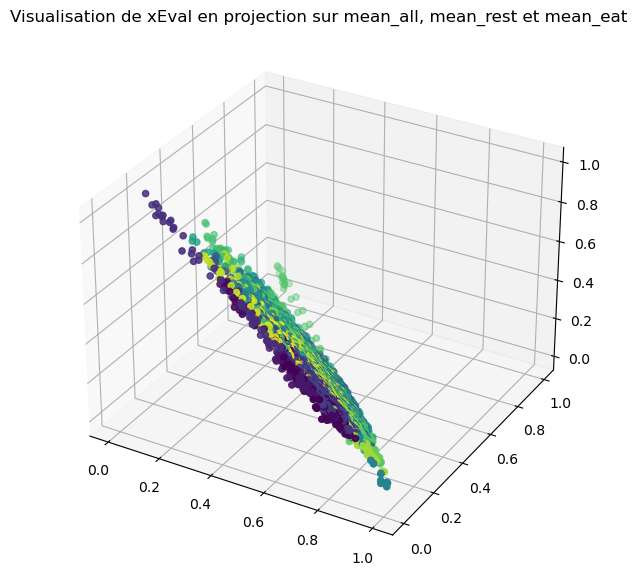

In [10]:
fig2 = plt.figure(figsize = (10, 7))
ax2 = plt.axes(projection ="3d")
 
# Creating plot
ax2.scatter3D(dataEval['mean_all'], dataEval['mean_rest'], dataEval['mean_eat'], c=dataEval['secs_elapsed'])
plt.title("Visualisation de xEval en projection sur mean_all, mean_rest et mean_eat")
# show plot
plt.show()

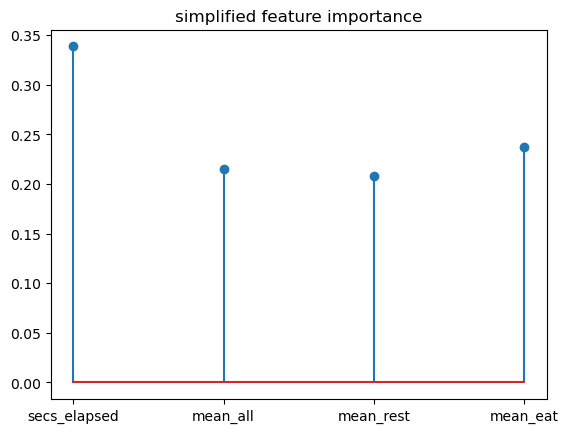

In [11]:
"""importance des colonnes"""
model = RandomForestClassifier(100) # 100 decision trees
model.fit(X_simplified, y)
f_simplified = model.feature_importances_
plt.stem(X_simplified.columns, f_simplified) 
plt.title("simplified feature importance")
plt.show()

In [12]:
"""réduction de la dimension"""
pca = PCA(3)
X_simplified_reduced = pca.fit(X_simplified).transform(X_simplified)
X_simplified_reduced = pd.DataFrame(X_simplified_reduced)
#X_simplified_reduced = pd.concat([X_simplified['secs_elapsed'], X_simplified_reduced], axis = 1)
X_simplified_reduced.columns = ['dim1', 'dim2', 'dim3']

XEval_simplified_reduced = pca.fit(dataEval).transform(dataEval)
XEval_simplified_reduced = pd.DataFrame(XEval_simplified_reduced)
XEval_simplified_reduced.columns = ['dim1', 'dim2', 'dim3']

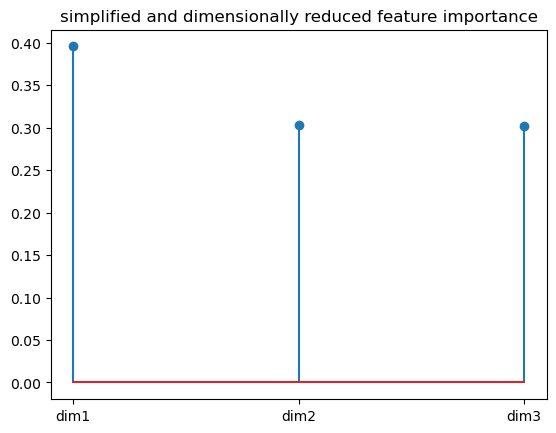

In [13]:
model.fit(X_simplified_reduced, y)
f_simplified_reduced = model.feature_importances_
plt.stem(['dim1', 'dim2', 'dim3'], f_simplified_reduced) 
plt.title("simplified and dimensionally reduced feature importance")
plt.show()

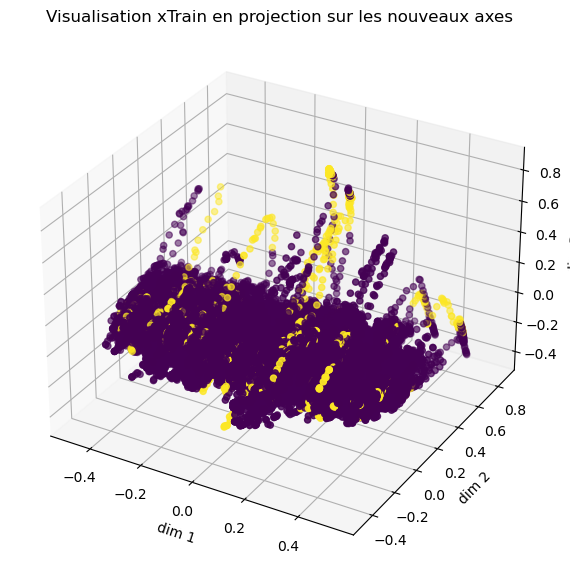

In [14]:
"""Affichage en dimension réduite"""
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(X_simplified_reduced['dim1'], X_simplified_reduced['dim2'], X_simplified_reduced['dim3'], c=y)
plt.title("Visualisation xTrain en projection sur les nouveaux axes")

ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('dim 3')
# show plot
plt.show()

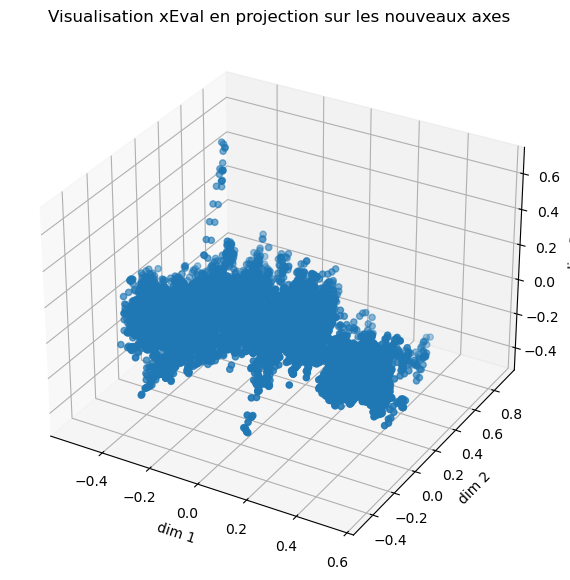

In [15]:
"""Affichage en dimension réduite"""
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(XEval_simplified_reduced['dim1'], XEval_simplified_reduced['dim2'], XEval_simplified_reduced['dim3'])
plt.title("Visualisation xEval en projection sur les nouveaux axes")

ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('dim 3')
# show plot
plt.show()

In [16]:
"""DEBUT CREATION DE MODELES"""
xtrain, xtest , ytrain, ytest = train_test_split(X_simplified, y, test_size=0.1, random_state=4)

In [17]:
"""gradient boosting"""
gb = GradientBoostingClassifier(max_depth=21).fit(xtrain, ytrain)
print("f1 score = {}".format(f1_score(ytest, gb.predict(xtest))))
print(confusion_matrix(ytest, gb.predict(xtest)))

f1 score = 0.6294642857142857
[[8021   53]
 [ 279  282]]


In [18]:
"""Random forest"""
rf = RandomForestClassifier(100).fit(xtrain, ytrain)
print("f1 score = {}".format(f1_score(ytest, rf.predict(xtest))))
print(confusion_matrix(ytest, rf.predict(xtest)))

f1 score = 0.5765983112183353
[[8045   29]
 [ 322  239]]


In [19]:
"""KNN"""
r = range(1, 25)
liste = []
for i in r:
    kn = KNeighborsClassifier(i).fit(xtrain, ytrain)
    ypred = kn.predict(xtest)
    liste.append(f1_score(ytest, ypred))
print("Nombre de voisins optimal : {}".format(np.argmax(liste) + 1))
print("f1 score = {}".format(liste[np.argmax(liste)]))
kn = KNeighborsClassifier(np.argmax(liste) + 1).fit(xtrain, ytrain)
print(confusion_matrix(ytest, kn.predict(xtest)))

Nombre de voisins optimal : 1
f1 score = 0.5281385281385281
[[7785  289]
 [ 256  305]]


In [20]:
sc = StackingClassifier([('rf', rf),
                         ('kn', kn),
                         ('gb', gb)],
                         final_estimator=LogisticRegression())
sc.fit(xtrain, ytrain)
print("f1 score = {}".format(f1_score(ytest, sc.predict(xtest))))
print(confusion_matrix(ytest, sc.predict(xtest)))

f1 score = 0.6701791359325606
[[8004   70]
 [ 243  318]]


In [21]:
print(np.sum(sc.predict(xtest)))
print(np.sum(ytest))

388.0
561.0


In [22]:
xEval = ETL('xEval.csv', simplified=True)
xEval.iloc[:,0:4] = MinMaxScaler().fit(xEval.iloc[:,0:4]).transform(xEval.iloc[:,0:4])
xEval.describe()

,secs_elapsed,mean_all,mean_rest,mean_eat
count,11832.000000,11832.000000,11832.000000,11832.000000
mean,0.492674,0.580292,0.324035,0.213930
std,0.293078,0.128765,0.097956,0.111815
min,0.000000,0.000000,0.000000,0.000000
25%,0.236735,0.509558,0.253424,0.133873
50%,0.473469,0.599867,0.331367,0.200145
75%,0.749400,0.670525,0.391224,0.267699
max,1.000000,1.000000,1.000000,1.000000


In [25]:
"""A rendre"""
gb = GradientBoostingClassifier(max_depth=21).fit(X_simplified, y)
ypred = gb.predict(xEval)
np.sum(ypred)

2499.0

In [95]:
np.savetxt("yEval.csv", ypred, delimiter=",")

2587.0

In [99]:
yeval = np.genfromtxt('yEval_gradient_boosting.csv', delimiter=',')
print(np.where(yeval == 1))

(array([   81,    82,   122, ..., 11814, 11815, 11816], dtype=int64),)
